Выполнил: Тазиев Тимур

#### Дан файл эксель с заказами клиентов (у одного клиента может быть несколько заказов) 

- user_id – идентификатор пользователя
- checks - сумма покупки

In [1]:
# загрузка данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# настройки для вывода графиков
sns.set(rc={'figure.figsize': (10,4),'figure.dpi': (80)},style='darkgrid')

# считываем данные
df = pd.read_excel('dz4.xlsx')
df.rename(columns={'cheks': 'check'},inplace=True)
df['check'] = df['check'].round(2)


#### ***A/A тестирование представляет собой метод статистического контроля, в рамках которого:***
- **Идентичные группы:** Две одинаковые или практически одинаковые группы.
- **Одни и те же условия:** Группы подвергаются одним и тем же условиям эксперимента.
- **Стабильность перед основным тестом:** Проверка системы или инструментов на стабильность перед основным тестированием.
- **Цель — исключить систематические различия:** Убеждение в отсутствии значимых различий между группами до начала основного эксперимента.

### `графики распределения`

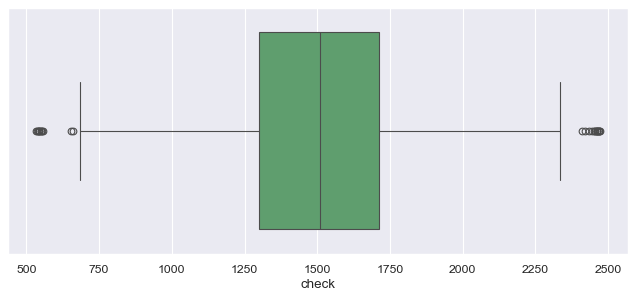

In [2]:
sns.boxplot(data=df,x='check',color='g');

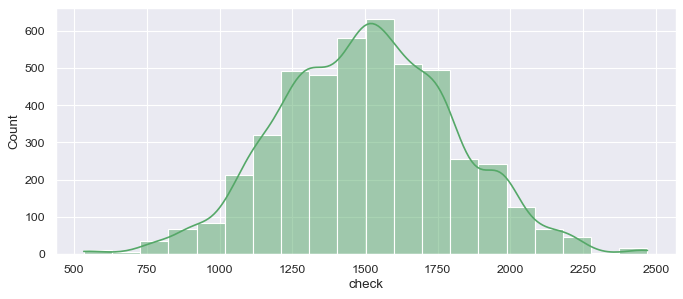

In [3]:
sns.histplot(data=df.check, kde=True, bins=20, color='g');

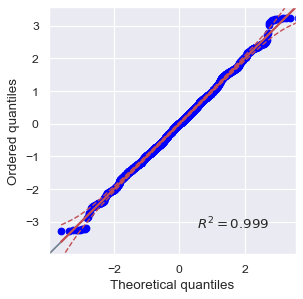

In [4]:
pg.qqplot(df.check);

### 1. Проверить, что распределение p-value на А/А-тестах для среднего чека (глобальное среднее) в по-юзерном тесте далеко не идеально в t-критерии, сделать вывод о применимости t-тест.

**Прежде чем выполнять t-test мы должны убедиться что выполнены условия**:
- Выборки должны быть случайными          `(да)`
- Выборки не зависят друг от друга        `(да)`
- Равенство дисперсий(гомоскедантичность) `(да)`
- Распределение нормальное                `(да)`

`выборки разделены случайным образом с помощью np.random.choice()`

In [5]:
np.random.seed(42)
# средняя цена чека в по-юзерном тесте
means_by_user = df.groupby('user_id')['check'].mean().reset_index()

# Создадим две идентичные группы, используя np.random.choice. запишем все в колонку 'group'
means_by_user['group'] = np.random.choice([1, 2], size=1000, p=[0.5, 0.5])

`Выборки не зависят друг от друга` 
- так как чеки сначала были усреднены для каждого пользователя, затем разделены на группы
- если было бы сразу разделение, то чеки одного и того же user_id могли быть в двух группах сразу, тогда была бы связь

`гомоскедантичность`

In [6]:
pg.homoscedasticity(data= means_by_user, dv = 'check', group='group', method='levene')

,W,pval,equal_var
levene,1.401338,0.236782,True


`нормальность распределения`

In [7]:
pg.normality(data=means_by_user,dv='check', group='group',method='normaltest').reset_index()

,group,W,pval,normal
0,1,1.642125,0.439964,True
1,2,0.135017,0.934720,True


#### создание списка p-val и проверка распределения

In [8]:
# создание списка p-val
from scipy.stats import ttest_ind
pvals = []
a = means_by_user[means_by_user.group == 1]['check']
b = means_by_user[means_by_user.group == 2]['check']

for _ in range(2000):
    t_stat, p_value = ttest_ind(a.sample(100), b.sample(100))
    pvals.append(p_value)

,W,pval,normal
0,996.69614,3.716919e-217,False


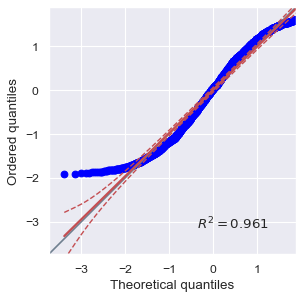

In [9]:
# проверка на нормальность
pg.qqplot(pvals);
pg.normality(data=pvals,method='normaltest')

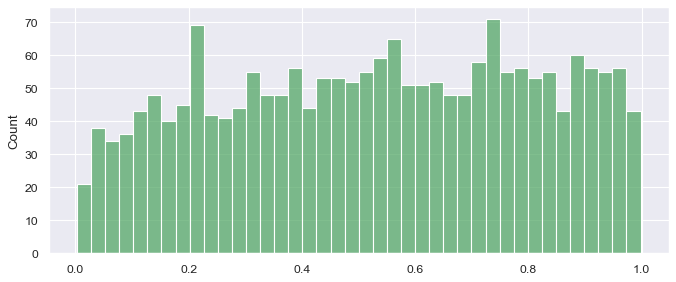

In [10]:
sns.histplot(data=pvals,bins=40, color='g');

### 2. Проверить через распределение p-value на А/А-тестах, работает ли дельта-метод для глобального среднего.

In [11]:
p_vals = []

for _ in range(10000):
    # Создание случайного шума для каждой группы
    noise_a = np.random.normal(0, 1, len(a))
    noise_b = np.random.normal(0, 1, len(b))
    
    # Добавление случайного шума к данным каждой группы
    first = a + noise_a
    second = b + noise_b

    # Вычисление p-value по t-тесту для каждой итерации
    _, p_value = ttest_ind(first, second)
    p_vals.append(p_value)

# Вывод среднего значения p-value
print(f'Среднее p-values: {np.mean(p_vals).round(3)}')


Среднее p-values: 0.951


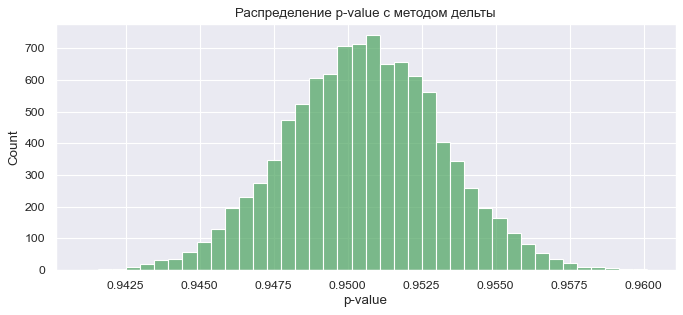

In [12]:
# Построение гистограммы распределения p-value
sns.histplot(p_vals, bins=40, color='g')
plt.title('Распределение p-value с методом дельты')
plt.xlabel('p-value');

In [13]:
pg.normality(p_vals,method='normaltest')

,W,pval,normal
0,0.019343,0.990375,True


**Вывод:**  `дельта-метод для глобального среднего в данном случае работает достаточно хорошо. Распределение p-value показывает себя согласно ожиданиям`

### 3. Проверить аналогично прошлым пунктам применимость t-теста для нормализованного (двойного) среднего.

Как я понял: 
- двойная средняя - `это процесс центрирования или нормализации относительно двух различных средних значений.`

In [14]:
p_vals = []

for _ in range(10000):   
    
    # Создание случайного шума
    noise_a = np.random.normal(0, 1, len(a))
    noise_b = np.random.normal(0, 1, len(b))
    
    # Нормализация данных обеих групп
    norm_a = (a - a.mean()) / a.std()
    norm_b = (b - b.mean()) / b.std()
    
    # Добавление случайного шума к нормализованным данным
    group_a = norm_a + noise_a
    group_b = norm_b + noise_b

    # Применение t-теста к нормализованным данным с шумом
    _, p_value = ttest_ind(group_a, group_b)
    p_vals.append(p_value)

print(f'Среднее p-values: {np.mean(p_vals).round(3)}')

Среднее p-values: 0.608


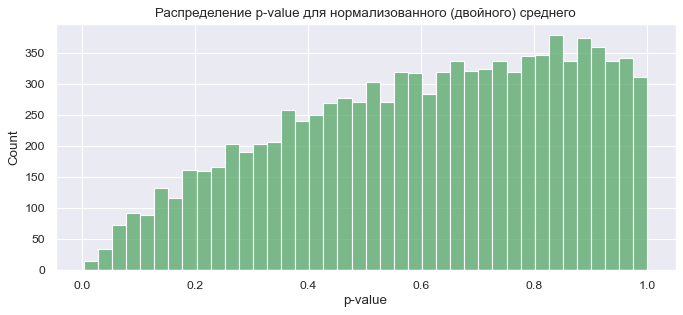

In [15]:
# Построение гистограммы распределения p-value
sns.histplot(p_vals, bins=40, color='g')
plt.title('Распределение p-value для нормализованного (двойного) среднего')
plt.xlabel('p-value');

**Вывод:** `Неравномерное распределение p-value может указывать на то, что t-тест может быть менее применим в этих условиях, поскольку он предполагает равномерное распределение p-value при соблюдении нулевой гипотезы.`

### 4. Сделать симуляции А/А-тестов таким образом – сгенерить эффект для таргетной группы так, чтобы среднее у него было 0, а дисперсия какая-то ненулевая. Проверить, что нормализованное среднее все еще стабильно в t-тесте.

In [16]:
# Задаем параметры симуляции
sample_size = 1000  
effect_mean = 0  
effect_std = 1  

control_group = np.random.normal(loc=0, scale=1, size=sample_size)
target_group = np.random.normal(loc=effect_mean, scale=effect_std, size=sample_size)

p_values = []
for _ in range(10000):
    # Генерируем новые данные для каждой итерации
    control_group = np.random.normal(loc=0, scale=1, size=sample_size)
    target_group = np.random.normal(loc=effect_mean, scale=effect_std, size=sample_size)
    
    # Выполняем t-тест и сохраняем p-value
    _, p_value = ttest_ind(control_group, target_group)
    p_values.append(p_value)


print("5ти процентый квантиль p-value распределения:", np.quantile(a = p_values, q=0.05))

5ти процентый квантиль p-value распределения: 0.0516998814767729


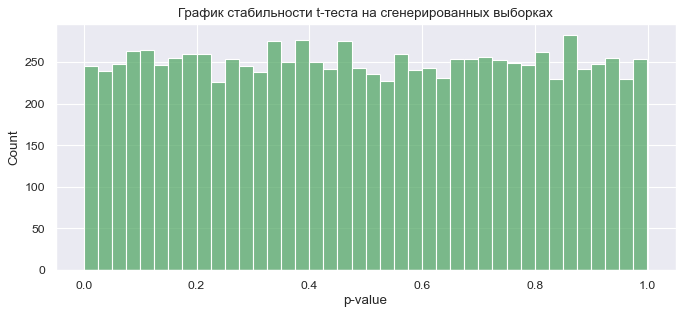

In [17]:
# Построение гистограммы распределения p-value
sns.histplot(p_values, bins=40, color='g')
plt.title('График стабильности t-теста на сгенерированных выборках')
plt.xlabel('p-value');

**Вывод:** `Равномерное распределение p-value в симуляции A/A-тестов, где все значения от 0 до 1 присутствуют в примерно равном количестве (около 250 для каждого интервала), а 5-процентный квантиль p-value составляет приблизительно 0.054, указывает на стабильность нормализованного среднего в t-тесте. Это свидетельствует о сохранении уровня значимости теста при условии равенства средних в обеих группах и подтверждает его корректность при оценке различий между ними`


### 5. Аналогично предыдущему пункту сгенерить эффект для таргетной группы так, чтобы среднее у него было 0 и не-нулевая дисперсия, но при этом средний эффект на пользователя был  скоррелирован с кол-вом заказов. Проверить, работает ли t-тест для нормализованного среднего

In [72]:
# Генерируем данные для количества заказов
order_count = np.random.normal(loc= 10, scale=2 , size=1000)

# Создаем эффект, коррелирующий с количеством заказов
effect = 0.5 * order_count + np.random.normal(loc= 0, scale=1, size=1000)

In [73]:
# Нормализация данных
order_count_normalized = (order_count - order_count.mean()) / order_count.std()
effect_normalized = (effect - effect.mean()) / effect.std()

t_statistic_norm, p_value_norm = ttest_ind(order_count_normalized, effect_normalized)

# Вывод результатов
print("T-статистика для нормализованных данных:", t_statistic_norm)
print("p-значение для нормализованных данных:", p_value_norm)

T-статистика для нормализованных данных: -1.4530449323291144e-14
p-значение для нормализованных данных: 0.9999999999999885


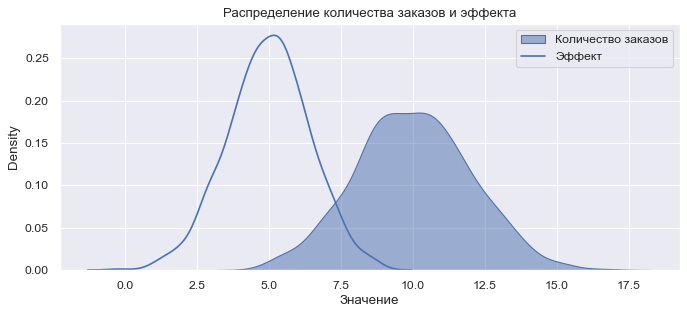

In [82]:
sns.kdeplot(order_count, label='Количество заказов',fill=True, alpha=.5)
sns.kdeplot(effect, label='Эффект')
plt.legend()
plt.title('Распределение количества заказов и эффекта')
plt.xlabel('Значение');

**Вывод:** `результаты t-теста указывают на то, что нет статистически значимых различий между нормализованными средними значениями 'количества заказов' и 'эффекта'.`